MONOMER GUI DETECTOR


In [1]:
import cv2
import numpy as np
import pandas as pd
#import tqdm for jupyter notebook
from tqdm.notebook import tqdm, trange
from scipy.ndimage   import gaussian_filter

DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
#movie = '130721_CCA60_RAW'
#movie ='280523 AM100 568'
movie ='AM100 568 280523 stabilized'

MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
#import gaussian from opencv
#from cv2 import GaussianBlur as gaussian

In [2]:
filter_sigma = 25
imgs_float = np.load(MOVIE_PATH + 'np/gel.npy') # replace with your images

imgs = np.zeros(imgs_float.shape, dtype='uint8')
imgs_float[np.isnan(imgs_float)] = 0
for t in trange(len(imgs_float)):
    img = imgs_float[t]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img = img.astype(np.uint8)
    imgs[t] = img
gel = np.load(MOVIE_PATH + 'np/gel.npy', mmap_mode='r')
gel_corrected = np.zeros(gel.shape)
for t in range(len(gel)):
    gel_corrected[t] = gel[t]/gaussian_filter(np.mean(gel[t,0:5,:,:],axis = 0),filter_sigma)
gel = gel_corrected

  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\amityu\AppData\Local\Temp\ipykernel_30896\134959804.py:14: RuntimeWarning: divide by zero encountered in divide
  gel_corrected[t] = gel[t]/gaussian_filter(np.mean(gel[t,0:5,:,:],axis = 0),filter_sigma)
C:\Users\amityu\AppData\Local\Temp\ipykernel_30896\134959804.py:14: RuntimeWarning: invalid value encountered in divide
  gel_corrected[t] = gel[t]/gaussian_filter(np.mean(gel[t,0:5,:,:],axis = 0),filter_sigma)


In [3]:
monomer_data_df = pd.DataFrame()
#save dataframes
monomer_data_df.to_csv(MOVIE_PATH + 'np/monomer_rect.csv')


In [ ]:
import cv2
import numpy as np
global iy
# Global variables
gap_from_surface = 10
img_index = 0
enlarge_image_factor = 2
df = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv', index_col=0)
iy = 0
if len(df) > 0:
    img_index = 0
    iz = df.iloc[0].values[0].astype(int)
    iy = df.iloc[0].values[1].astype(int)
    ix = df.iloc[0].values[2].astype(int)
    r_size = df.iloc[0].values[3].astype(int)
    y_gap = df.iloc[0].values[4].astype(int)
    gap_from_surface = df.iloc[0].values[7].astype(int)
    mean = df.iloc[0].values[5].astype(float)
    std = df.iloc[0].values[6].astype(float)


else:
    df['Z'] = [0]* len(imgs)
    df['Y'] = [0]* len(imgs)
    df['X'] = [0]* len(imgs)
    df['r_size'] = [15]* len(imgs)
    df['y_gap'] = [20]* len(imgs)
    df['mean'] = [0]* len(imgs)
    df['std'] = [0]* len(imgs)
    df['gap_from_surface'] = [0]* len(imgs)
    img_index=0
    iz, iy_tmp, ix,r_size, y_gap, _, _ , gap_from_surface = tuple(int(element) for element in tuple(df.iloc[img_index]))



# Define the draw_rectangle callback function
def draw_rectangle(event, x, z, flags, param):

    global ix, iz, iy, img, img_index, r_size, img_orig, y_gap, gap_from_surface, mean, std

    if event == cv2.EVENT_LBUTTONDOWN:
        ix, iz = x , z
        i_data = gel[img_index, iz+gap_from_surface:iz+r_size, iy:iy+y_gap, ix:ix+r_size]
        i_data = i_data[i_data>0]
        mean = np.nanmean(i_data)
        std = np.nanstd(i_data)
        if np.isnan(mean):
            mean = 0
        if np.isnan(std):
            std = 0
        df.iloc[img_index] = pd.Series([iz,iy,ix,r_size, y_gap, mean, std, gap_from_surface], index=df.columns)

    elif event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:  # scroll up
            if iy + y_gap < imgs.shape[2]:
                iy+= y_gap  # cycle through images

        else:  # scroll down
            iy-= y_gap  # cycle through images
            if iy< 0:
                iy = 0
    #img_index =24
    img_orig =cv2.convertScaleAbs( np.max(imgs[img_index, :,iy:iy+y_gap,:], axis=1), alpha=1, beta=0)# load the new image

    img = img_orig.copy()

    iz, iy_tmp, ix,r_size, y_gap, _, _ , gap_from_surface = tuple(int(element) for element in tuple(df.iloc[img_index]))
    if iy == iy_tmp:
        color = img.mean()
        cv2.rectangle(img, pt1=(ix, iz), pt2=(ix+r_size, iz+r_size), color= color, thickness=2)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    colored_image = cv2.applyColorMap(img, cv2.COLORMAP_JET)

    # Display the image
    cv2.imshow('image', colored_image)
    #cv2.imshow('image', img)

    data_string = f'Time: {img_index}, X: {ix}, Y: {iy}, Z: {iz} , Y MIP size: {y_gap}'
    data_string2 = f' , r_size: {r_size}, gap_from_surface: {gap_from_surface}'
    data_string3 = f' , mean: {mean:.2f}, std: {std:.2f}'
    exit_string = 's  to save, q to quit, 2/8 to change time'
    data_img = np.zeros((500,600))
    position = (10, 50)  # bottom-left corner of the text
    position_exit = (10, 100)  # bottom-left corner of the text
    position2 = (10, 150)  # bottom-left corner of the text
    position3 = (10, 200)  # bottom-left corner of the text

    fontScale = 0.7
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)  # white color
    thickness = 2  # line thickness
    cv2.putText(data_img, data_string,  position, font, fontScale, color, thickness)
    cv2.putText(data_img, exit_string, position_exit, font, fontScale, color, thickness)
    cv2.putText(data_img, data_string2, position2, font, fontScale, color, thickness)
    cv2.putText(data_img, data_string3, position3, font, fontScale, color, thickness)
    cv2.imshow('Data', data_img)

# 3D array of images
img = np.max(imgs[img_index, :,iy:iy+y_gap,:], axis=1) .copy()

# Create the named window and set the mouse callback
cv2.namedWindow('image',cv2.WINDOW_NORMAL)
cv2.namedWindow('Data', cv2.WINDOW_NORMAL)

cv2.setMouseCallback('image', draw_rectangle)
#cv2.setMouseCallback('Data', getData)


# Show the image and wait for the user to close the window
while True:
    colored_image = cv2.applyColorMap(img, cv2.COLORMAP_JET)

    # Display the image
    cv2.imshow('image', colored_image)
    key = cv2.waitKey(1) & 0xFF
    if key  == ord('q'):
        break
    elif key == ord('2'):
        img_index +=1
        if img_index >= len(imgs):
            img_index = 0
        iy = df.iloc[img_index].values[1].astype(int)
        draw_rectangle(None, 0, 0, 1, 0)
    elif key == ord('8'):
        img_index -=1
        if img_index < 0:
            img_index = len(imgs)-1
        draw_rectangle(None, 0, 0, -1, 0)
        iy = df.iloc[img_index].values[1].astype(int)
    elif key == ord('s'):
        df.to_csv(MOVIE_PATH + 'np/monomer_rect.csv', index=True)

cv2.destroyAllWindows()

# Print the saved coordinates


NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

NameError: name 'mean' is not defined

C:\Users\amityu\AppData\Local\anaconda3\envs\opencv_pip\lib\site-packages\numpy\lib\nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

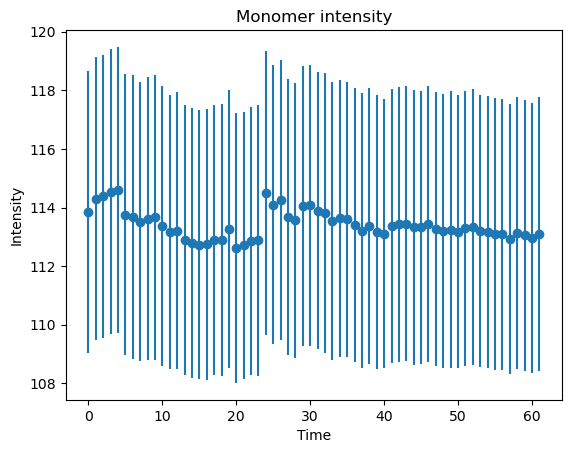

In [94]:
df = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv', index_col=0)
plt.errorbar(np.arange(len(df)), df['mean'], yerr=df['std'], fmt='o')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Monomer intensity')
plt.show()
